In [25]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from sqlalchemy import create_engine
import statsmodels.api as sm 
%matplotlib inline

# Predicting Temperature

1. First, load the dataset from the weatherinszeged table from Thinkful's database.

In [4]:
postgres_user = 'dsbc_student'
postgres_pw = '7*.8G9QH21'
postgres_host = '142.93.121.174'
postgres_port = '5432'
postgres_db = 'weatherinszeged'

engine = create_engine('postgresql://{}:{}@{}:{}/{}'.format(
    postgres_user, postgres_pw, postgres_host, postgres_port, postgres_db))
weather_df = pd.read_sql_query('select * from weatherinszeged',con=engine)

engine.dispose()

weather_df.head()

,date,summary,preciptype,temperature,apparenttemperature,humidity,windspeed,windbearing,visibility,loudcover,pressure,dailysummary
0,2006-03-31 22:00:00+00:00,Partly Cloudy,rain,9.472222,7.388889,0.89,14.1197,251.0,15.8263,0.0,1015.13,Partly cloudy throughout the day.
1,2006-03-31 23:00:00+00:00,Partly Cloudy,rain,9.355556,7.227778,0.86,14.2646,259.0,15.8263,0.0,1015.63,Partly cloudy throughout the day.
2,2006-04-01 00:00:00+00:00,Mostly Cloudy,rain,9.377778,9.377778,0.89,3.9284,204.0,14.9569,0.0,1015.94,Partly cloudy throughout the day.
3,2006-04-01 01:00:00+00:00,Partly Cloudy,rain,8.288889,5.944444,0.83,14.1036,269.0,15.8263,0.0,1016.41,Partly cloudy throughout the day.
4,2006-04-01 02:00:00+00:00,Mostly Cloudy,rain,8.755556,6.977778,0.83,11.0446,259.0,15.8263,0.0,1016.51,Partly cloudy throughout the day.


2. Build a regression model where the target variable is temperature. As explanatory variables, use humidity, windspeed, windbearing, and pressure. Estimate the model using OLS.

In [9]:
#Sort data into dependent and independent variables
Y = weather_df['temperature']
X = weather_df[['humidity', 'windspeed', 'windbearing', 'pressure']]
X = sm.add_constant(X)

results = sm.OLS(Y,X).fit()
results.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:            temperature   R-squared:                       0.421
Model:                            OLS   Adj. R-squared:                  0.421
Method:                 Least Squares   F-statistic:                 1.750e+04
Date:                Thu, 15 Aug 2019   Prob (F-statistic):               0.00
Time:                        08:13:34   Log-Likelihood:            -3.2821e+05
No. Observations:               96453   AIC:                         6.564e+05
Df Residuals:                   96448   BIC:                         6.565e+05
Df Model:                           4                                         
Covariance Type:            nonrobust                                         
===============================================================================
                  coef    std err          t      P>|t|      [0.025      0.975]
-------------------------------------------------------------------------------
const          37.9264      0.233    162.709      0.000      37.470      38.383
humidity      -32.4962      0.123   -264.288      0.000     -32.737     -32.255
windspeed      -0.2014      0.003    -57.557      0.000      -0.208      -0.195
windbearing     0.0040      0.000     18.463      0.000       0.004       0.004
pressure       -0.0007      0.000     -3.452      0.001      -0.001      -0.000
==============================================================================
Omnibus:                     3375.432   Durbin-Watson:                   0.059
Prob(Omnibus):                  0.000   Jarque-Bera (JB):             3793.297
Skew:                          -0.455   Prob(JB):                         0.00
Kurtosis:                       3.339   Cond. No.                     1.06e+04
==============================================================================

Warnings:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
[2] The condition number is large, 1.06e+04. This might indicate that there are
strong multicollinearity or other numerical problems.
"""

3. Now, check if your model meets the Gauss-Markov Conditions above. If some of the assumptions are not met, discuss the implications of the violations for the correctness of your model.

Gauss-Markov Assumptions:

    -linearity of models in their coefficients
    -the error term should be zero on average
    -homoscedasticity
    -low multicollinearity
    -error terms should be uncorrelated with one another
    -features shouldn't be correlated with the errors
    -normality of the errors

# Linearity of the models in their coefficients

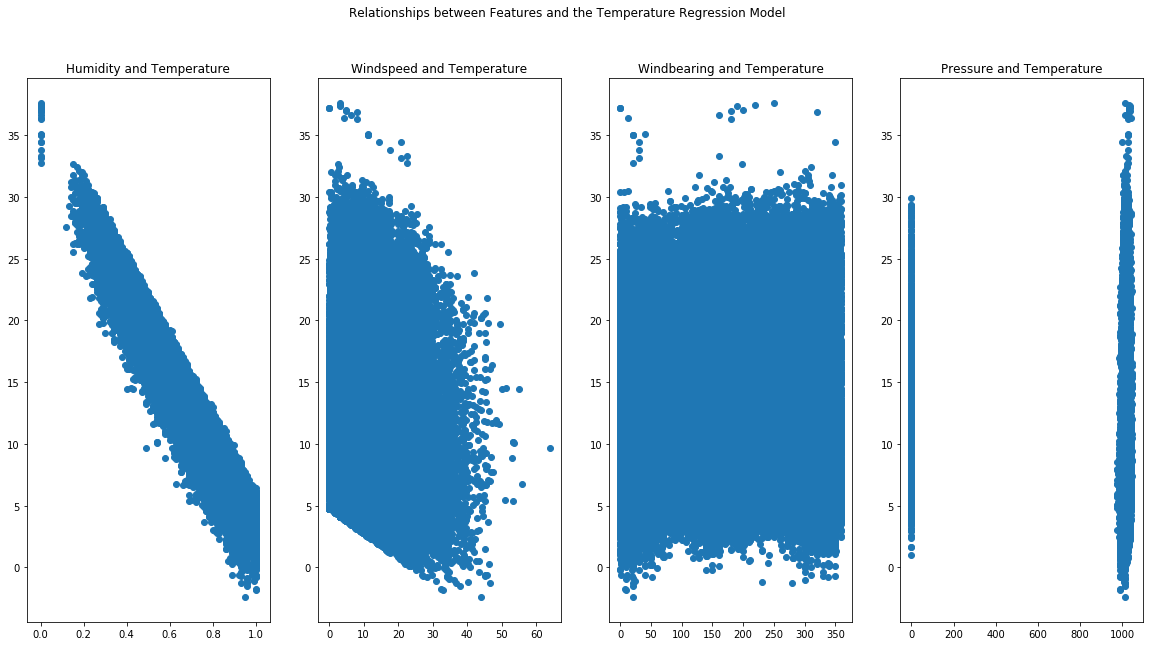

In [35]:
predictions = results.predict(X)
errors = Y - predictions

plt.figure(figsize=(20,10))

plt.subplot(1,4,1)
plt.scatter(X.humidity, predictions)
plt.title('Humidity and Temperature')

plt.subplot(1,4,2)
plt.scatter(X.windspeed, predictions)
plt.title('Windspeed and Temperature')

plt.subplot(1,4,3)
plt.scatter(X.windbearing, predictions)
plt.title('Windbearing and Temperature')

plt.subplot(1,4,4)
plt.scatter(X.pressure, predictions)
plt.title('Pressure and Temperature')

plt.suptitle('Relationships between Features and the Temperature Regression Model')
plt.show()

# The error term should be zero on average

In [36]:
print(errors.mean())

1.3645287066663584e-11


# Homoscedasticity

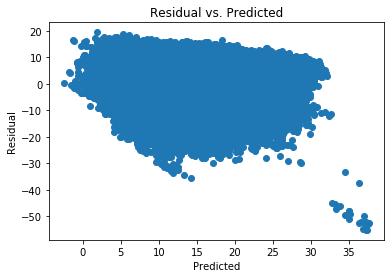

In [38]:
plt.scatter(predictions, errors)
plt.xlabel('Predicted')
plt.ylabel('Residual')
plt.title('Residual vs. Predicted')
plt.show()

It would appear that the error variance is heteroscedasic. Let's perform Bartlett and Levene tests to confirm.

In [39]:
from scipy.stats import bartlett
from scipy.stats import levene

bart_stats = bartlett(predictions, errors)
lev_stats = levene(predictions, errors)

print("Bartlett test statistic value is {0:3g} and p value is {1:.3g}".format(bart_stats[0], bart_stats[1]))
print("Levene test statistic value is {0:3g} and p value is {1:.3g}".format(lev_stats[0], lev_stats[1]))

Bartlett test statistic value is 2464.84 and p value is 0
Levene test statistic value is 2321.24 and p value is 0


The tests confirm that the error variance is heteroscedastic (p < 0.05). To improve this model, one should consider applying a transformation to the Temperatute variable investigating outliers, and exploring other features that may reduce the heteroscedacticity.

# Low multicollinearity

In [40]:
x_corrs = X.corr()
x_corrs

,const,humidity,windspeed,windbearing,pressure
const,NaN,NaN,NaN,NaN,NaN
humidity,NaN,1.000000,-0.224951,0.000735,0.005454
windspeed,NaN,-0.224951,1.000000,0.103822,-0.049263
windbearing,NaN,0.000735,0.103822,1.000000,-0.011651
pressure,NaN,0.005454,-0.049263,-0.011651,1.000000


There is low multicollinearity among our features, the strongest correlation is between humidity and windspeed with a correlation of -0.22.

# Error terms should be uncorrelated with one another

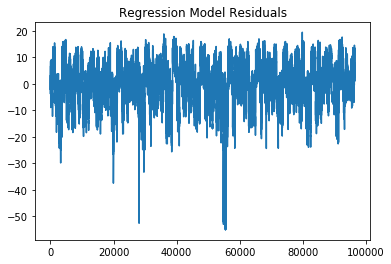

In [42]:
plt.plot(errors)
plt.title('Regression Model Residuals')
plt.show()

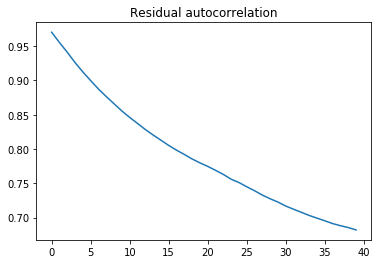

In [45]:
from statsmodels.tsa.stattools import acf

acf_data = acf(errors)

plt.plot(acf_data[1:])
plt.title('Residual autocorrelation')
plt.show()

Errors should be uncorrelated with themselves. The errors are highly correlated, indicating that a useful variable was likely left out of this model.

# Features shouldn't be correlated with the errors

In [52]:
X['errors'] = errors 
error_corrs = X.corr()
error_corrs.errors

const                   NaN
humidity       2.059990e-15
windspeed     -7.796606e-15
windbearing   -1.007911e-14
pressure      -1.258349e-14
errors         1.000000e+00
Name: errors, dtype: float64

The correlations between features and errors are all extremely small, indicating that this assumption was not violated.

# Evaluating the House prices regression model

In [99]:
postgres_user = 'dsbc_student'
postgres_pw = '7*.8G9QH21'
postgres_host = '142.93.121.174'
postgres_port = '5432'
postgres_db = 'houseprices'

engine = create_engine('postgresql://{}:{}@{}:{}/{}'.format(
    postgres_user, postgres_pw, postgres_host, postgres_port, postgres_db))
prices_df = pd.read_sql_query('select * from houseprices',con=engine)

engine.dispose()

In [100]:
#Create series of continuous variable names, check that all continuous variables are numerical

cont_vars = pd.Series(['saleprice', 'yrsold', 'miscval', 'poolarea','screenporch', 'threessnporch', 'enclosedporch',
                             'wooddecksf', 'openporchsf','garagearea', 'garageyrblt', 'grlivarea', 'lowqualfinsf', 'firstflrsf', 
                             'secondflrsf','totalbsmtsf', 'bsmtunfsf', 'bsmtfinsf1', 'bsmtfinsf2', 'masvnrarea', 
                             'yearbuilt', 'yearremodadd','lotarea', 'lotfrontage'])

#Create series of the categorical variable names

cat_vars = []

for var in prices_df.columns:
    if cont_vars.str.contains(var).any() == False:
        cat_vars.append(var)

cat_vars = pd.Series(cat_vars)

#Check that no variables are in both variable lists

for var in prices_df.columns:
    if cont_vars.str.contains(var).any() & cat_vars.str.contains(var).any():
        print(var)

In [101]:
#Convert categorical variables to numerically coded categories

coded_df = prices_df.copy()
coded_df.sort_values(by='saleprice')
codebook = {}

for var in cat_vars:
    if  coded_df[var].dtype == 'O':
        
        #Create replace dict for each variable
        labels = coded_df[var].unique()
        replace_dict = {k: v for k,v in zip(labels,range(len(labels)))}
        
        #Add var entry to codebook and replace in dataframe
        codebook.update({var: replace_dict})
        coded_df.loc[:,var] = coded_df[var].replace(replace_dict) 

In [102]:
#Boxcox transform our dependent variable, add to list of cont_vars 

coded_df['boxcox_saleprice'] = stats.boxcox(coded_df['saleprice'])[0]
cont_vars = list(cont_vars)
cont_vars.insert(0,'boxcox_saleprice')

In [103]:
#Sort variables by their relevance in the model

#Loop through cat_vars and conduct One-Way Anova across the groups in each cat_var for boxcox_saleprice

import statsmodels.api as sm
from statsmodels.formula.api import ols
F = []
p = []

for var in cat_vars:
    mod_str = 'boxcox_saleprice ~ ' + var
    mod = ols(mod_str, data=coded_df).fit()
    aov_table= sm.stats.anova_lm(mod, typ=2)
    F.append(aov_table['F'][0])
    p.append(aov_table['PR(>F)'][0])
    
#Save results of anova in df with variable names

aov_res = pd.DataFrame(cat_vars, columns=['var'])
aov_res['F'] = F
aov_res['p-value'] = p 
aov_res.sort_values(by='F', ascending=False, inplace=True)

#Create correlation matrix, sort by saleprice
cont_corrs = coded_df[cont_vars].corr()
cont_corrs.sort_values(by='boxcox_saleprice',axis=0, ascending=False, inplace=True)

In [104]:
#Create series of top 10 categorical variables
features = aov_res['var'][:10]

#Append series of continuous variables with greater than 0.5 correlation and remove saleprice vars and secondflrsf
cont_features = list(cont_corrs.loc[cont_corrs['boxcox_saleprice']>0.5, 'boxcox_saleprice'].index)
for var in ['boxcox_saleprice', 'saleprice']: cont_features.remove(var) 
    
features = features.append(pd.Series(cont_features), ignore_index=True)

In [105]:
coded_df.loc[:,features] = coded_df.loc[:,features].fillna(0)

In [106]:
#Sort data into dependent and independent variables
Y = coded_df['boxcox_saleprice']
X = coded_df[features]
X = sm.add_constant(X)


results = sm.OLS(Y,X).fit()
results.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:       boxcox_saleprice   R-squared:                       0.833
Model:                            OLS   Adj. R-squared:                  0.831
Method:                 Least Squares   F-statistic:                     422.2
Date:                Thu, 15 Aug 2019   Prob (F-statistic):               0.00
Time:                        09:27:18   Log-Likelihood:                 1925.6
No. Observations:                1460   AIC:                            -3815.
Df Residuals:                    1442   BIC:                            -3720.
Df Model:                          17                                         
Covariance Type:            nonrobust                                         
================================================================================
                   coef    std err          t      P>|t|      [0.025      0.975]
--------------------------------------------------------------------------------
const            4.6515      0.271     17.188      0.000       4.121       5.182
overallqual      0.0319      0.002     15.102      0.000       0.028       0.036
garagecars       0.0174      0.006      3.147      0.002       0.007       0.028
fullbath        -0.0020      0.005     -0.427      0.669      -0.011       0.007
totrmsabvgrd     0.0052      0.002      2.677      0.008       0.001       0.009
fireplaces       0.0275      0.004      6.561      0.000       0.019       0.036
foundation      -0.0069      0.003     -2.324      0.020      -0.013      -0.001
heatingqc       -0.0087      0.002     -3.910      0.000      -0.013      -0.004
fireplacequ      0.0016      0.002      0.688      0.492      -0.003       0.006
bsmtfintype1    -0.0031      0.001     -2.556      0.011      -0.005      -0.001
exterqual       -0.0029      0.004     -0.835      0.404      -0.010       0.004
grlivarea     6.735e-05   7.51e-06      8.967      0.000    5.26e-05    8.21e-05
garagearea    3.075e-05    1.8e-05      1.706      0.088    -4.6e-06    6.61e-05
totalbsmtsf   2.788e-05    7.9e-06      3.530      0.000    1.24e-05    4.34e-05
firstflrsf    2.336e-05      9e-06      2.594      0.010     5.7e-06     4.1e-05
yearbuilt        0.0006   9.57e-05      6.136      0.000       0.000       0.001
yearremodadd     0.0008      0.000      6.664      0.000       0.001       0.001
garageyrblt   1.774e-05   4.93e-06      3.598      0.000    8.07e-06    2.74e-05
==============================================================================
Omnibus:                      952.949   Durbin-Watson:                   1.981
Prob(Omnibus):                  0.000   Jarque-Bera (JB):            34266.485
Skew:                          -2.501   Prob(JB):                         0.00
Kurtosis:                      26.201   Cond. No.                     6.46e+05
==============================================================================

Warnings:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
[2] The condition number is large, 6.46e+05. This might indicate that there are
strong multicollinearity or other numerical problems.
"""

# Linearity of the models in their coefficients

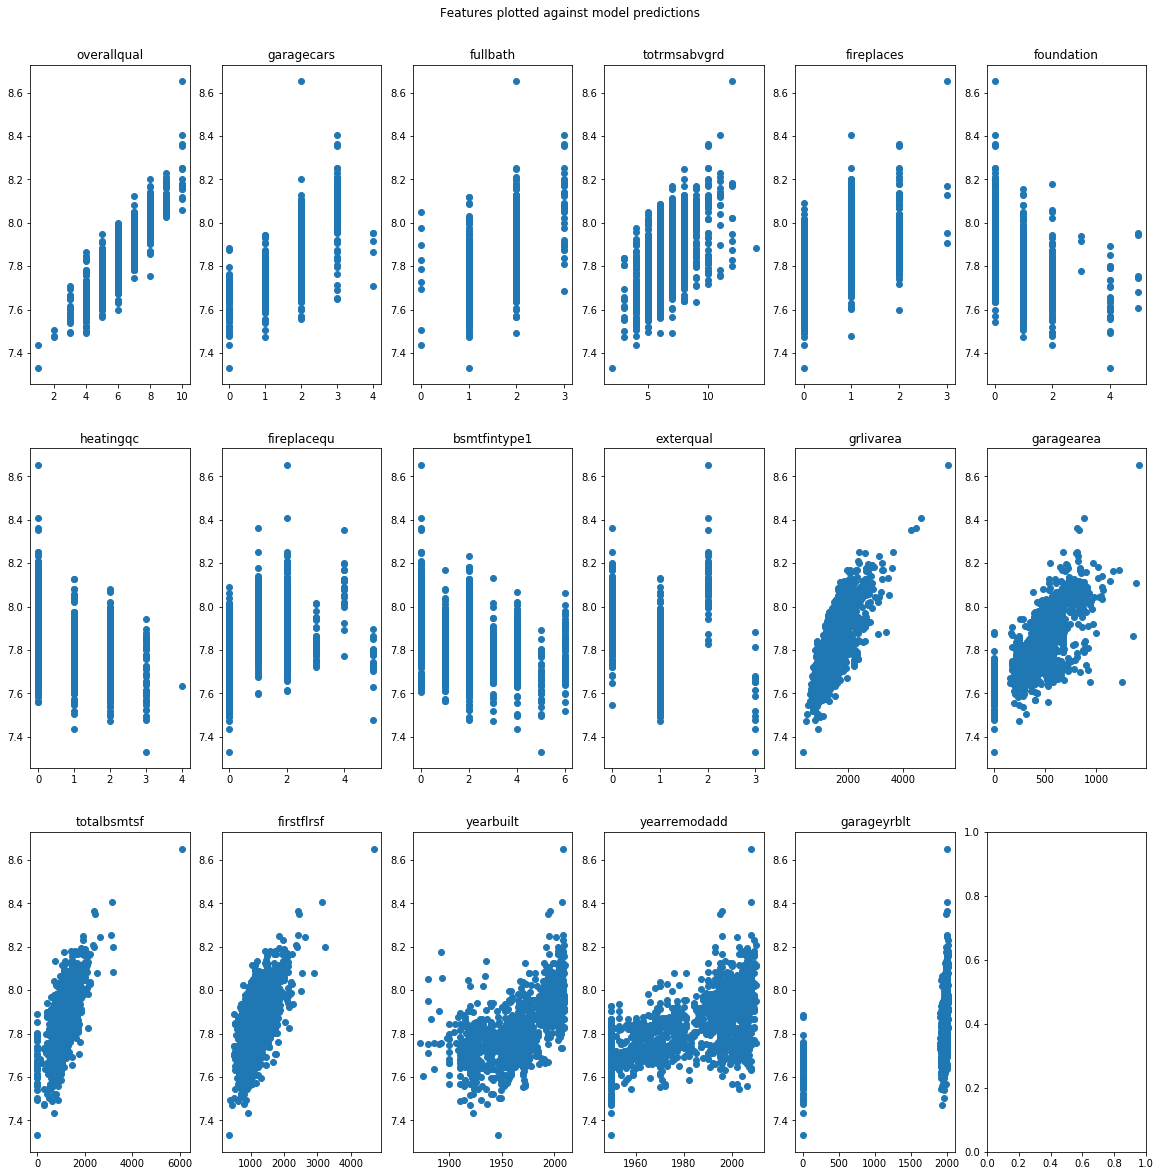

In [107]:
predictions = results.predict(X)
errors = Y - predictions

fig, axes = plt.subplots(3,6, figsize=(20,20))

for i in range(len(features)):
    plt.subplot(3,6,i+1)
    plt.scatter(X[features[i]], predictions)
    plt.title(features[i])
    
plt.suptitle('Features plotted against model predictions', y=0.92)
plt.show()

The features all appear to demostrate linearity with the dependent variable.

# The error term on average should be zero

In [108]:
print(errors.mean())

1.1110807859756889e-13


# Homoscedasticity

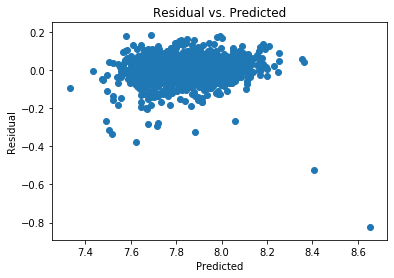

In [109]:
plt.scatter(predictions, errors)
plt.xlabel('Predicted')
plt.ylabel('Residual')
plt.title('Residual vs. Predicted')
plt.show()

In [110]:
bart_stats = bartlett(predictions, errors)
lev_stats = levene(predictions, errors)

print("Bartlett test statistic value is {0:3g} and p value is {1:.3g}".format(bart_stats[0], bart_stats[1]))
print("Levene test statistic value is {0:3g} and p value is {1:.3g}".format(lev_stats[0], lev_stats[1]))

Bartlett test statistic value is 852.794 and p value is 1.8e-187
Levene test statistic value is 812.793 and p value is 6.33e-158


The residuals are not homescedastic. From the figure above, it would appear that this is predominately due to a few outliers in the features. Cleaning these up would likely reduce this problem.

# Low multicollinearity

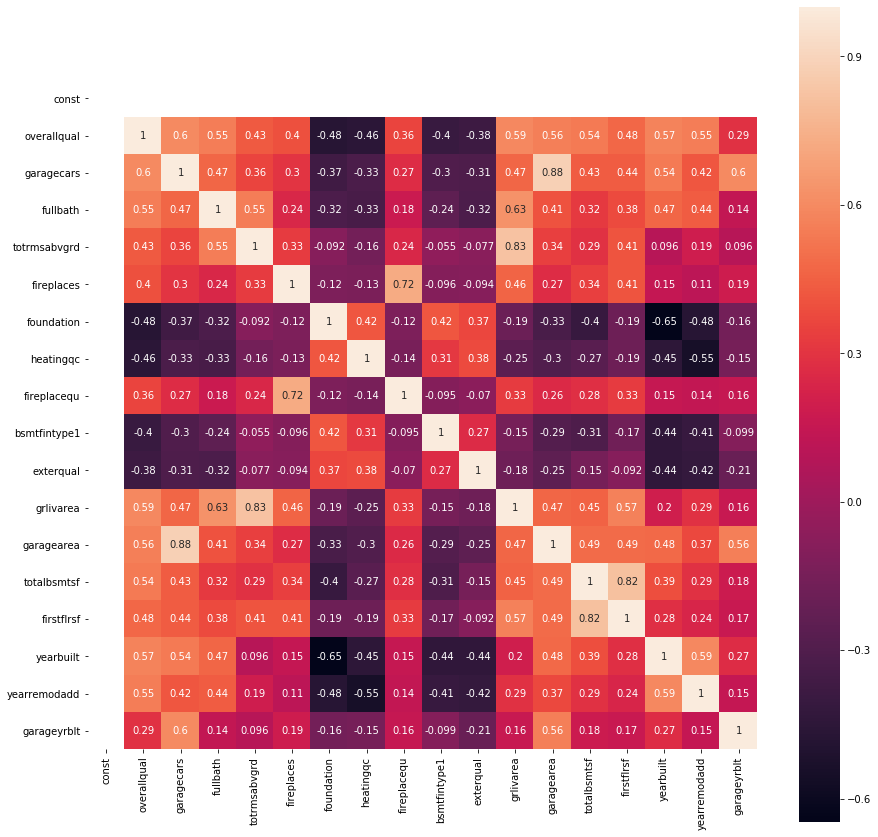

In [113]:
import seaborn as sns

x_corrs = X.corr()

plt.figure(figsize=(15,15))
sns.heatmap(x_corrs, annot=True, square=True)
plt.show()

This is likely the largest problem with the model, there is quite a bit of multicollinearity. This is confirmed with the high condition number that was output by the results table above. To fix this issue, many of these variables will need to undergo PCA or be combined/omitted through some other means.

# Error terms should be uncorrelated with one another


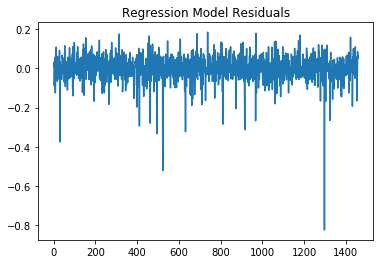

In [114]:
plt.plot(errors)
plt.title('Regression Model Residuals')
plt.show()

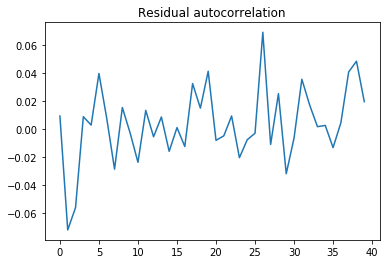

In [115]:
acf_data = acf(errors)

plt.plot(acf_data[1:])
plt.title('Residual autocorrelation')
plt.show()

The residuals are not correlated with one another.

# Features shouldn't be correlated with the errors

In [116]:
X['errors'] = errors 
error_corrs = X.corr()
error_corrs.errors

const                    NaN
overallqual     6.856700e-14
garagecars      8.554104e-14
fullbath        3.369024e-14
totrmsabvgrd    1.470272e-14
fireplaces      3.985179e-14
foundation     -4.500448e-14
heatingqc      -3.655882e-14
fireplacequ     3.488287e-14
bsmtfintype1   -3.262924e-14
exterqual      -3.194283e-14
grlivarea       2.417911e-14
garagearea      8.331219e-14
totalbsmtsf     6.294063e-14
firstflrsf      5.855432e-14
yearbuilt       6.323426e-14
yearremodadd    4.265537e-14
garageyrblt     6.589720e-14
errors          1.000000e+00
Name: errors, dtype: float64

None of the features are correlated with the model residuals.